In [ ]:
!pip install numpy
!pip install seaborn
!pip install sklearn
!pip install matplotlib

# Imports

In [7]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn import metrics
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

METADATA_FILE_PATH = "census_income_metadata.txt"
TRAIN_FILE_PATH = "census_income_learn.csv"
TEST_FILE_PATH = "census_income_test.csv"
COLUMNS_PATH = "columns.json"

# Creation des dataframes de train et de test

In [8]:
def load_columns(path):
    with open(path, 'r') as f:
        return json.load(f)

def save_json(path, data):
    with open(path, 'w') as f:
        json.dump(data, f, indent=4)

def get_continuous_columns(columns):
    res = []
    for key, value in columns.items():
        if key != "MARSUPWT" and value == ["continuous"]:
            res.append(key)
    return res

def get_categorical_columns(columns):
    res = []
    for key, value in columns.items():
        if value != ["continuous"]:
            res.append(key)
    return res

In [51]:
columns = load_columns(path=COLUMNS_PATH)
column_names = list(columns.keys()) + ["INCOME"]

# On supprime toutes les lignes comportant des NaN après avoir transformé les "?" en NaN
train = pd.read_csv(TRAIN_FILE_PATH, sep=', ', names=column_names, na_values=["?"], engine="python").dropna()
test = pd.read_csv(TEST_FILE_PATH, sep=', ', names=column_names, na_values=["?"], engine="python").dropna()

# On remplace la colonne à prédire par des valeurs binaires
train.INCOME = train.INCOME.replace(["- 50000.", "50000+."], [0, 1])
test.INCOME = test.INCOME.replace(["- 50000.", "50000+."], [0, 1])

# On drop la colonne "instance weight"
train.drop(["MARSUPWT"], axis=1, inplace=True)
test.drop(["MARSUPWT"], axis=1, inplace=True)
column_names.remove("MARSUPWT")
train.shape, test.shape

((94462, 41), (47082, 41))

On supprime les colonnes contenant une seule valeur

In [52]:
for col in column_names:
    if len(train[col].unique()) == 1 or len(test[col].unique()) == 1:
        train.drop([col], axis=1, inplace=True)
        test.drop([col], axis=1, inplace=True)

In [53]:
train.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,INCOME
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,0
6,42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,0
9,34,Private,4,37,Some college but no degree,0,Not in universe,Married-civilian spouse present,Construction,Machine operators assmblrs & inspctrs,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,0


# Plot de quelques valeurs du dataset

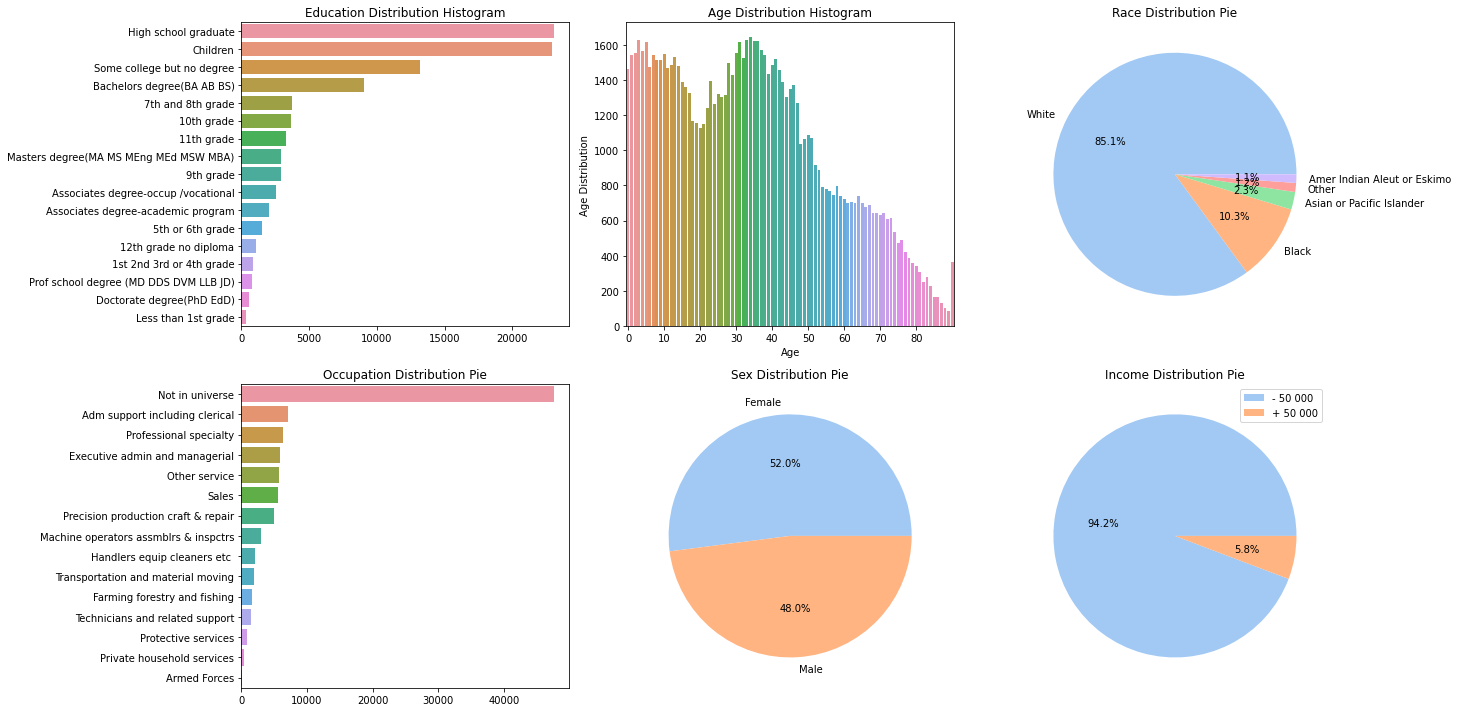

In [54]:
plt.figure(figsize=(20, 10))
colors = sns.color_palette('pastel')

# Age distribution
ax = plt.subplot(232)
age_count = train.AAGE.value_counts()
sns.barplot(x=age_count.index, y=age_count.values)
min_tick, max_tick = np.min(age_count.index), np.max(age_count.index)
plt.xticks(range(min_tick, max_tick, 10))
ax.set_xlabel("Age")
ax.set_ylabel("Age Distribution")
ax.set_title("Age Distribution Histogram")

# Education Distribution
ax = plt.subplot(231)
education_count = train.AHGA.value_counts()
sns.barplot(x=education_count.values, y=education_count.index)
ax.set_title("Education Distribution Histogram")

# Race Distribution
ax = plt.subplot(233)
race_counts = train.ARACE.value_counts()
ax.pie(race_counts, labels=race_counts.index, colors=colors, autopct='%.1f%%')
ax.set_title("Race Distribution Pie")

# Sex Distribution
ax = plt.subplot(235)
sex_counts = train.ASEX.value_counts()
ax.pie(sex_counts, labels=sex_counts.index, colors=colors, autopct='%.1f%%')
ax.set_title("Sex Distribution Pie")

# Occupation Distribution
ax = plt.subplot(234)
occupation_counts = train.AMJOCC.value_counts()
sns.barplot(x=occupation_counts.values, y=occupation_counts.index)
ax.set_title("Occupation Distribution Pie")

# Income Distribution
ax = plt.subplot(236)
income_counts = train.INCOME.value_counts()
ax.pie(income_counts, labels=income_counts.index, labeldistance=None, colors=colors, autopct='%.1f%%')
ax.set_title("Income Distribution Pie")
ax.legend(["- 50 000", "+ 50 000"])

plt.tight_layout()
plt.show()

# Plot des correlations

En affichant les correlations des valeurs numériques, on peut remarquer quelques liens assez logiques de notre dataset. On a par exemple des paramètres comme l'âge (AAGE) et les bénéfices attribués au vétérans (VETYN) qui semblent étroitement liés, ou encore le type d'industrie (ADTIND) ainsi que le nombre de semaine de travail dans l'année (WKSWORK), etc...  
Même si ces liens peuvent sembler assez évidents, cette heatmap montre qu'ils sont tout de même présents dans le dataset. Ce dernier semble donc très représentatif de ce que l'on retrouve dans notre quotidien.  
Les correlations peuvent permettre de réduire la dimensionnalité de notre dataset, en effet on pourrait supprimer les paramètres trop correlés entre eux qui ne seraient qu'une redondance des données.

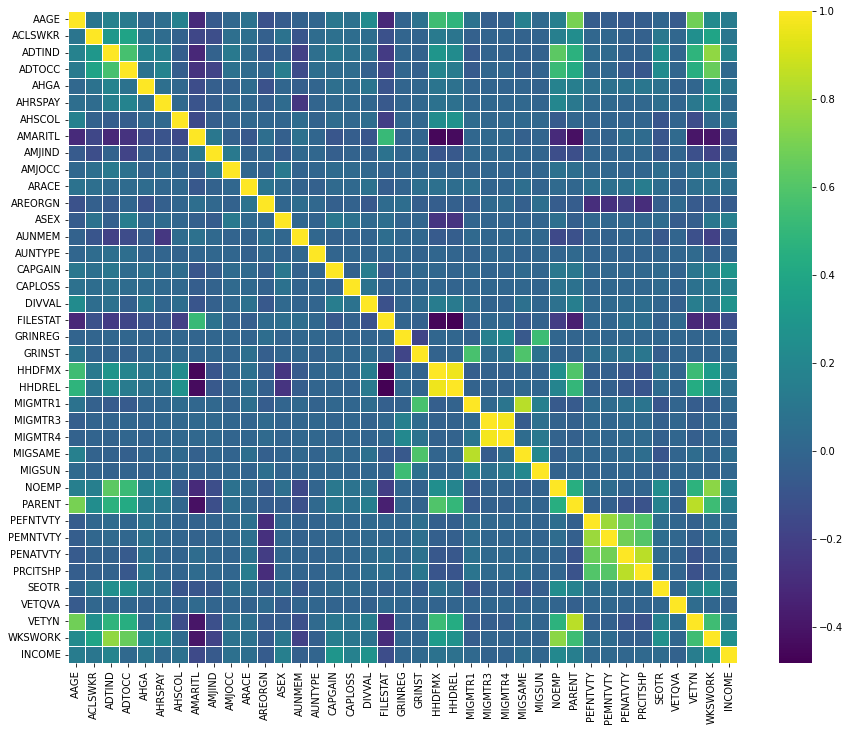

In [55]:
# On change nos données représentées par des strings grâce au LabelEncoder afin de calculer leurs correlations
dataset = train.apply(LabelEncoder().fit_transform)
plt.figure(figsize=(15, 12))
sns.heatmap(dataset.corr(), linewidths=.8, cmap="viridis")
plt.show()

Grâce aux correlations, on se rend compte que certaines colonnes sont étroitement liées:
- les colonnes concernant les statistiques sur la famille (HHDFMX et HHDREL)
- les colonnes concernant les codes de migration (MIGMTR3 et MIGMTR4)
- les colonnes concernant les pays de naissances de notre famille et notre citoyenneté (PEFNTVTY, PEMNTVTY, PENATVTY et PRCITSHP)

Supprimer certaines de ces colonnes pour n'en garder qu'une par catégorie semble donc être un bon choix.

In [61]:
train.drop(["HHDREL", "MIGMTR4", "PEFNTVTY", "PEMNTVTY", "PRCITSHP"], axis=1, inplace=True)
test.drop(["HHDREL", "MIGMTR4", "PEFNTVTY", "PEMNTVTY", "PRCITSHP"], axis=1, inplace=True)

KeyError: "['HHDREL' 'MIGMTR4' 'PEFNTVTY' 'PEMNTVTY' 'PRCITSHP'] not found in axis"

# Séparation des datasets entre les données et les labels

On va maintenant encoder les valeurs categorical de notre dataset grâce au *OneHotEncoder*. On pourrait également utiliser le *LabelEncoder* pour réduire le nombre de dimensionnalités, cependant il suppose que les éléments sont reliés les uns aux autres ce qui n'est pas le cas ici.

In [59]:
train_X, train_y = train.iloc[:,0:-1], train.iloc[:,-1]
test_X, test_y = test.iloc[:,0:-1], test.iloc[:,-1]

dataset = pd.concat([train, test]).drop(["INCOME"], axis=1)
encoder = OneHotEncoder().fit(dataset)

train_X = encoder.transform(train_X).toarray()
test_X = encoder.transform(test_X).toarray()
train_X.shape, test_X.shape

((94462, 2864), (47082, 2864))

La PCA nous permettrait également de réduire la dimensionnalité globale de notre dataset, cependant il marche mieux sur des valeurs continues. Hors, on a ici une majorité de valeurs categorical, il n'est donc pas nécessaire de l'utiliser.

In [ ]:
# train_X = PCA().fit_transform(train_X) # 100s
# test_X = PCA().fit_transform(test_X) # 100s

Pour pallier à notre dataset très déséquilibré, on a plusieurs choix possibles:
- enlever des données de la classe majoritaire
- augmenter artificiellement la classe minoritaire
- spécifier à nos algorithmes l'équilibre de nos données grâce au paramètre *class_weight*

Dans notre cas, le jeu est tellement déséquilibré qu'aucune des solutions n'est vraiment efficace.

In [60]:
class_weight = {
    0: income_counts.values[0] / (income_counts.values[0] + income_counts.values[1]),
    1: income_counts.values[1] / (income_counts.values[0] + income_counts.values[1])
}
class_weight

{0: 0.9423895322987021, 1: 0.05761046770129788}

In [63]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(), # 60s
    # "Decision Tree": DecisionTreeClassifier(), # 94s
    # "SVC": SVC(), # 6s
    # "Gaussian NB": GaussianNB(), # 8s
    # "RandomForestClassifier": RandomForestClassifier(), # 180s
    # "AdaBoostClassifier": AdaBoostClassifier(), # 480s
    # "MLP Classifier": MLPClassifier() # 70s
}

In [64]:
for clf in dict_classifiers.values():
    clf.fit(train_X, train_y) # 7748s

C:\Users\lvi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:
dict_metrics = {
    "Accuracy": metrics.accuracy_score,
    "Precision": metrics.precision_score,
    "Recall": metrics.recall_score,
    "F1 Score": metrics.f1_score,
}

scores = []
for clf in dict_classifiers.values():
    pred = clf.predict(test_X)
    clf_scores = [metric(pred, test_y) for metric in dict_metrics.values()]
    scores.append(clf_scores)

pd.DataFrame(scores, index=dict_classifiers.keys(), columns=dict_metrics.keys())

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.960155,0.435254,0.760131,0.553546
